AS.430.271.81: M08 - Adam Thomas

# M08 Homework - KMeans Clustering and XGBoost

This JupyterLab Notebook will implement the following tasks:
- Load the NYC taxi data from [here](https://www.kaggle.com/c/nyc-taxi-trip-duration/data)
- Filter anomalous records
- Clip data to NYC shoreline
- Cluster pickup and dropoff locations using KMeans Clustering
- Create interpretable columns for machine learning (convert datetime and lat/lon values to hour of day, day of week, and distance)
- Predict taxi trip durations using XGBoost 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import colorcet
import datashader
import gc
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_error, silhouette_samples, silhouette_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import plot_importance

## Load NYC Taxi Data

Inspect initial data

In [3]:
df = pd.read_csv('train.csv')
df.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

Inspect dtypes and non-null counts

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Convert pickup_datetime and dropoff_datetime to datetime types

In [5]:
df[['pickup_datetime', 'dropoff_datetime']] = df[['pickup_datetime', 'dropoff_datetime']].apply(pd.to_datetime)

Inspect data statistics

In [6]:
df.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.458644e+06      1.458644e+06   1.458644e+06  
mean       -7.397342e+01      4.075180e+01   9.594923e+02  
std         7.064327e-02      3.589056e-02   5.237432e+03  
min        -1.219333e+02      3.218114e+01   1.000000e+00  
25%        -7.399133e+01      4.073588e+01   3.970000e+02  
50%        -7.397975e+01      4.075452e+01   6.620000e+02  
75%        -7.396301e+01      4.076981e+01   1.075000e+03  
max        -6.133553e+01      4.392103e+01   3.526282e+06

There are a few noticable data anomalies, let's remove these next.

## Filter / Clean Data

First, let's remove trips that have zero passengers

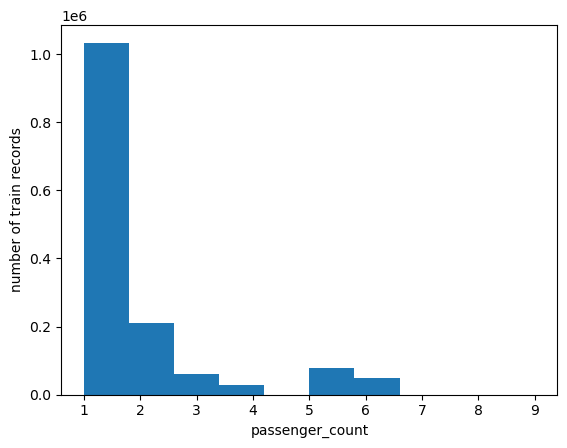

In [7]:
df = df[df['passenger_count'] > 0]
plt.hist(df['passenger_count'].values, bins=10)
plt.xlabel('passenger_count')
plt.ylabel('number of train records')
plt.show()

Now let's take a look at the trip duration data to see if there are any anomalies

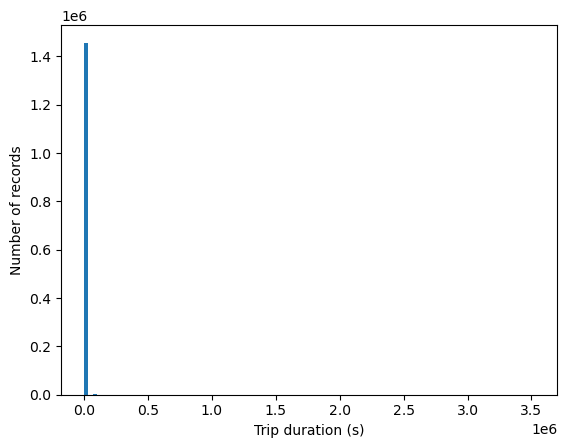

In [8]:
# Plot histogram of trips
plt.hist(df['trip_duration'].values, bins=100)
plt.xlabel('Trip duration (s)')
plt.ylabel('Number of records')
plt.show()

Something does not look right. Let's view the same data as a box plot to see what is going on

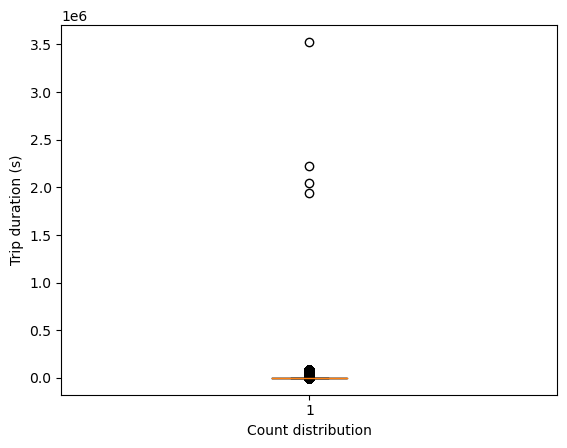

In [9]:
plt.boxplot(df['trip_duration'])
plt.xlabel('Count distribution')
plt.ylabel('Trip duration (s)')
plt.show()

This data is does not have a normal distribution, but already has some obvious outliers.
Let's look at a logarithmic version

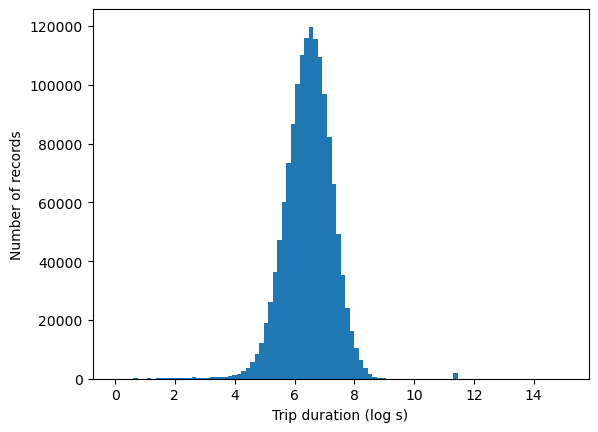

In [10]:
df['trip_duration_log'] = np.log(df['trip_duration'].values)
plt.hist(df['trip_duration_log'], bins=100)
plt.xlabel('Trip duration (log s)')
plt.ylabel('Number of records')
plt.show()

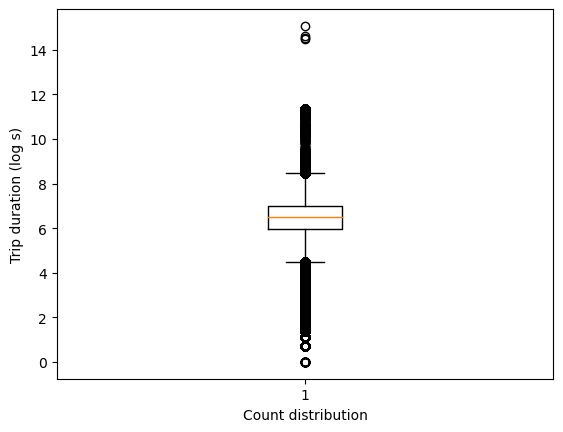

In [11]:
plt.boxplot(df['trip_duration_log'])
plt.xlabel('Count distribution')
plt.ylabel('Trip duration (log s)')
plt.show()

There are clearly some outliers at the extreme ends of the data, so let's only include everything within 2 standard deviations of the logarithmic mean.

In [12]:
m = np.mean(df['trip_duration_log'])
s = np.std(df['trip_duration_log'])
df = df[df['trip_duration_log'] <= m + (2*s)]
df = df[df['trip_duration_log'] >= m - (2*s)]

Now let's see how the logarithmic distribution has changed

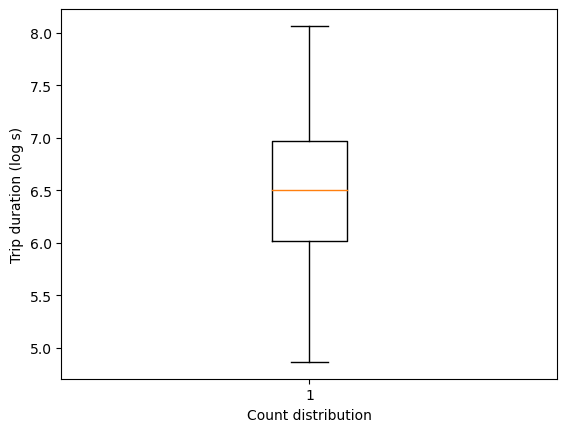

In [13]:
plt.boxplot(df['trip_duration_log'].values)
plt.xlabel('Count distribution')
plt.ylabel('Trip duration (log s)')
plt.show()

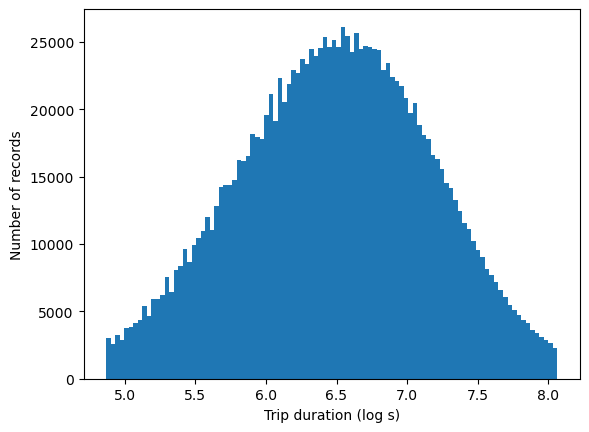

In [14]:
# df['trip_duration_log'] = np.log(df['trip_duration'].values)
plt.hist(df['trip_duration_log'], bins=100)
plt.xlabel('Trip duration (log s)')
plt.ylabel('Number of records')
plt.show()

The logarithmic blox plot and histogram plot above is much cleaner than before.
Let's plot the original trip duration historgram now that the outliers have been removed.

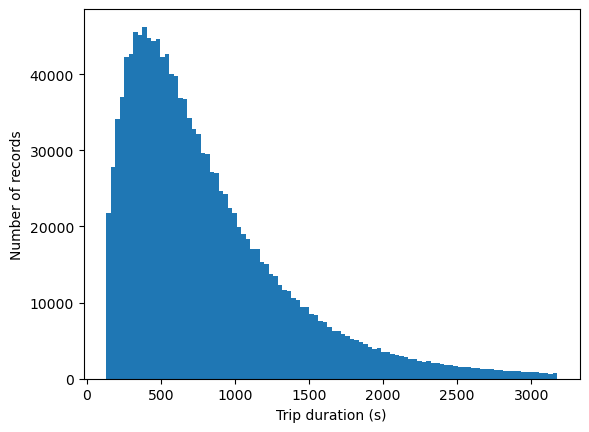

In [15]:
plt.hist(df['trip_duration'].values, bins=100)
plt.xlabel('Trip duration (s)')
plt.ylabel('Number of records')
plt.show()

In [16]:
df.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.405870e+06     1.405870e+06      1.405870e+06     1.405870e+06   
mean   1.534867e+00     1.665491e+00     -7.397474e+01     4.075137e+01   
std    4.987830e-01     1.314766e+00      7.006791e-02     3.185845e-02   
min    1.000000e+00     1.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399197e+01     4.073762e+01   
50%    2.000000e+00     1.000000e+00     -7.398192e+01     4.075414e+01   
75%    2.000000e+00     2.000000e+00     -7.396796e+01     4.076828e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  trip_duration_log  
count       1.405870e+06      1.405870e+06   1.405870e+06       1.405870e+06  
mean       -7.397402e+01      4.075206e+01   8.159133e+02       6.488958e+00  
std         7.009733e-02      3.500508e-02   5.530488e+02       6.678924e-01  
min        -1.219333e+02      3.218114e+01   1.300000e+02       4.867534e+00  
25%        -7.399136e+01      4.073611e+01   4.100000e+02       6.016157e+00  
50%        -7.397985e+01      4.075455e+01   6.680000e+02       6.504288e+00  
75%        -7.396338e+01      4.076974e+01   1.065000e+03       6.970730e+00  
max        -6.133553e+01      4.391176e+01   3.175000e+03       8.063063e+00

This makes a lot more sense. We now have the shortest trip taking 130 seconds (~ 2 mins) and the longest trip taking 3715 seconds (~ 1 hour).

## Clip Data to NYC shoreline

In [17]:
# Remove trips that are outside a smaller bounding box covering NYC
# Remove trips that have the same pickup and dropoff coordinates

xmin,ymin,xmax,ymax = [-74.021072,40.698340,-73.927002,40.851995]
df = df[(df['pickup_latitude'].between(ymin,ymax)) & 
        (df['pickup_longitude'].between(xmin,xmax)) & 
        (df['dropoff_latitude'].between(ymin,ymax)) & 
        (df['dropoff_longitude'].between(xmin,xmax)) &
        (df['pickup_latitude'] != df['dropoff_latitude']) & 
        (df['pickup_longitude'] != df['dropoff_longitude'])]

In [18]:
# Now clip pickup and dropoff locations to within detailed shoreline
land_boundary = gpd.read_file('State_Shorline_LL84.shp')
temp1_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.pickup_longitude, df.pickup_latitude), crs=f"EPSG:4326").clip(land_boundary)
temp2_df = gpd.GeoDataFrame(temp1_df, geometry=gpd.points_from_xy(temp1_df.dropoff_longitude, temp1_df.dropoff_latitude), crs=f"EPSG:4326").clip(land_boundary)

# Let's sample only 100000 points from the cleaned data, this will make the following analysis and ML model much faster
clean_df = temp2_df.sample(100000)

# clear some memory
del df
del temp1_df
del temp2_df
gc.collect()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


0

Plot visual aggregation of pickup locations to inspect geographically

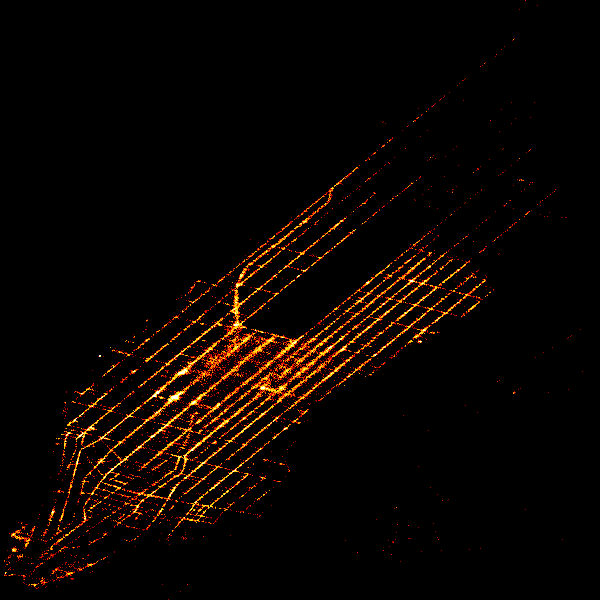

In [19]:
aggregated = datashader.Canvas().points(clean_df, 'pickup_longitude', 'pickup_latitude')
datashader.tf.set_background(datashader.tf.shade(aggregated, cmap=colorcet.fire), "black")

## Create Interpretable Columns
Before starting a training model, I will create different columns to represent time and location instead of using datetime and lat/lon.
These will be hour of day, day of week, and distance.

In [20]:
# hour of day based on pickup location
clean_df['hour'] = clean_df['pickup_datetime'].dt.hour

# day of week based on pickup location
clean_df['day'] = clean_df['pickup_datetime'].dt.dayofweek

Unfortunately the hour and day values create jump discontinuities, meaning that values like 11pm (23) and midnight (0) differ by 23, but are actually more similar in value than midnight (0) and 6am (6).
We can solve this by converting hour and day to cyclical values

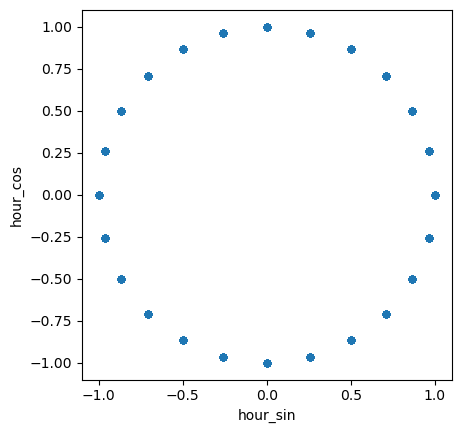

In [21]:
# Convert hour to hour_sin and hour_cos
clean_df['hour_sin'] = np.sin(2 * np.pi * clean_df['hour']/24.0)
clean_df['hour_cos'] = np.cos(2 * np.pi * clean_df['hour']/24.0)
# Plot cyclical pattern of hour
clean_df.plot.scatter('hour_sin', 'hour_cos').set_aspect('equal')

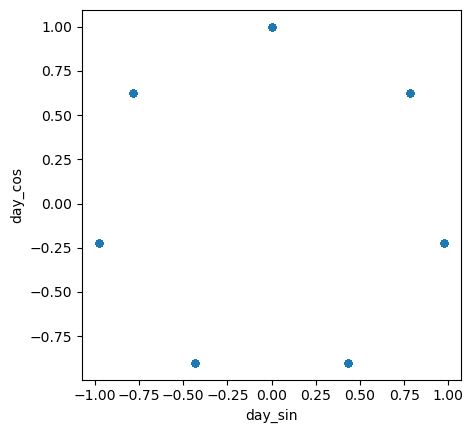

In [22]:
# Convert day to day_sin and day_cos
clean_df['day_sin'] = np.sin(2 * np.pi * clean_df['day']/7.0)
clean_df['day_cos'] = np.cos(2 * np.pi * clean_df['day']/7.0)
# Plot cyclical pattern of day
clean_df.plot.scatter('day_sin', 'day_cos').set_aspect('equal')

These are the results we are looking for.
Times and days that are more similar to one another are now closer together in value.

In [23]:
# Add a distance column to the cleaned dataframe based on the haversince function found here: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas/29546836#29546836
# Using the mean of the min and max radii of the Earth as 6,367.4445

def haversine_distance(lon1: pd.Series, lat1: pd.Series, lon2: pd.Series, lat2: pd.Series) -> pd.Series:
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367.4445 * c
    return km

clean_df['distance_km'] = haversine_distance(clean_df['pickup_longitude'],clean_df['pickup_latitude'],clean_df['dropoff_longitude'],clean_df['dropoff_latitude'])

## Cluster the pickup and dropoff locations using KMeans Clustering
Because the precise coorindate of each pickup and dropoff location is unique, it may be difficult to accurately predict the taxi journey time based on coordinates. Therefore, let's look at using KMeans Clustering to group the pickup and dropoff locations into aggregated areas.

In [24]:
# This multi-plot snippet is taken from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def plot_silhouette_analysis(X_input,frac_input,range_n_clusters):
    
    X = X_input.sample(frac=frac_input).values

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Longitude")
        ax2.set_ylabel("Latitude")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )
    plt.show()

In [25]:
# Unfortunately we don't know what the optimal clustering value should be, so let's also use Silhouette Analysis to determine a suitable n_clusters parameter in the range of 10 to 50.

def plot_silhouette_scores(X_input, frac_input, range_input):

    # To make things faster, clustering can be tested on a fraction subset of the data (e.g. 10%) because it should be evenly distributed. ~1.5 million records takes too long to test many clusters on.
    X = X_input.sample(frac=frac_input).values

    # perform silhouette analysis to optimize n_clusters
    silhouette_scores = []

    # Test clusters between 10 and 50
    for i in range_input:
        model = KMeans(n_clusters=i, random_state=42, n_init='auto')
        model.fit(X)
        score = silhouette_score(X, model.labels_)
        silhouette_scores.append(score)

    # Plot silhouette scores of clusters between 10 and 50
    plt.plot(range_input, silhouette_scores, marker='o')
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")

### KMeans Clustering for pickup locations

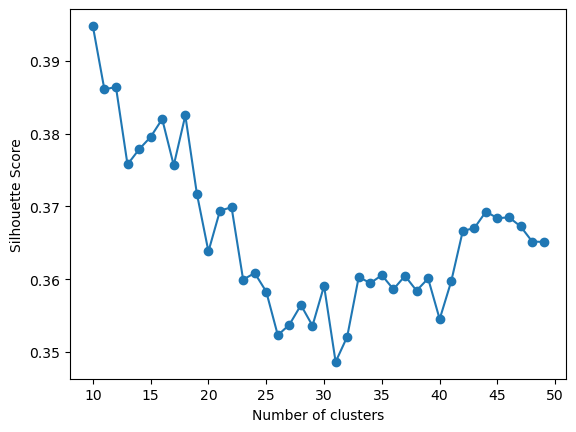

In [26]:
# Plot pickup location silhouette analysis results for clusters between 10 and 50
pickup_X = clean_df[['pickup_longitude', 'pickup_latitude']]
plot_silhouette_scores(pickup_X, 0.1, range(10,50))

You can see from the above plot that the silhouette score is the highest at 10 with another local maxima at 44.

Let's plot the silhouette results for 10 and 44 clusters on the data to compare the results visually.

For n_clusters = 10 The average silhouette_score is : 0.394978503832899
For n_clusters = 44 The average silhouette_score is : 0.3637869335090436


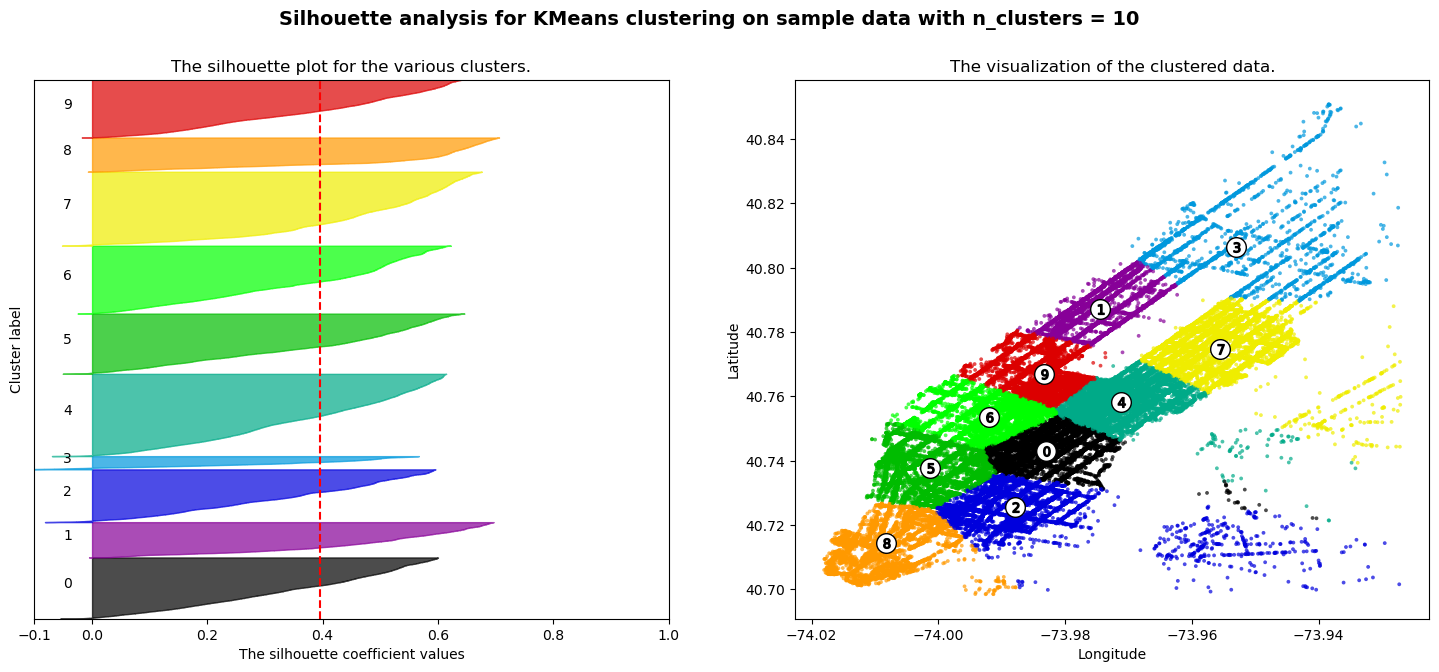

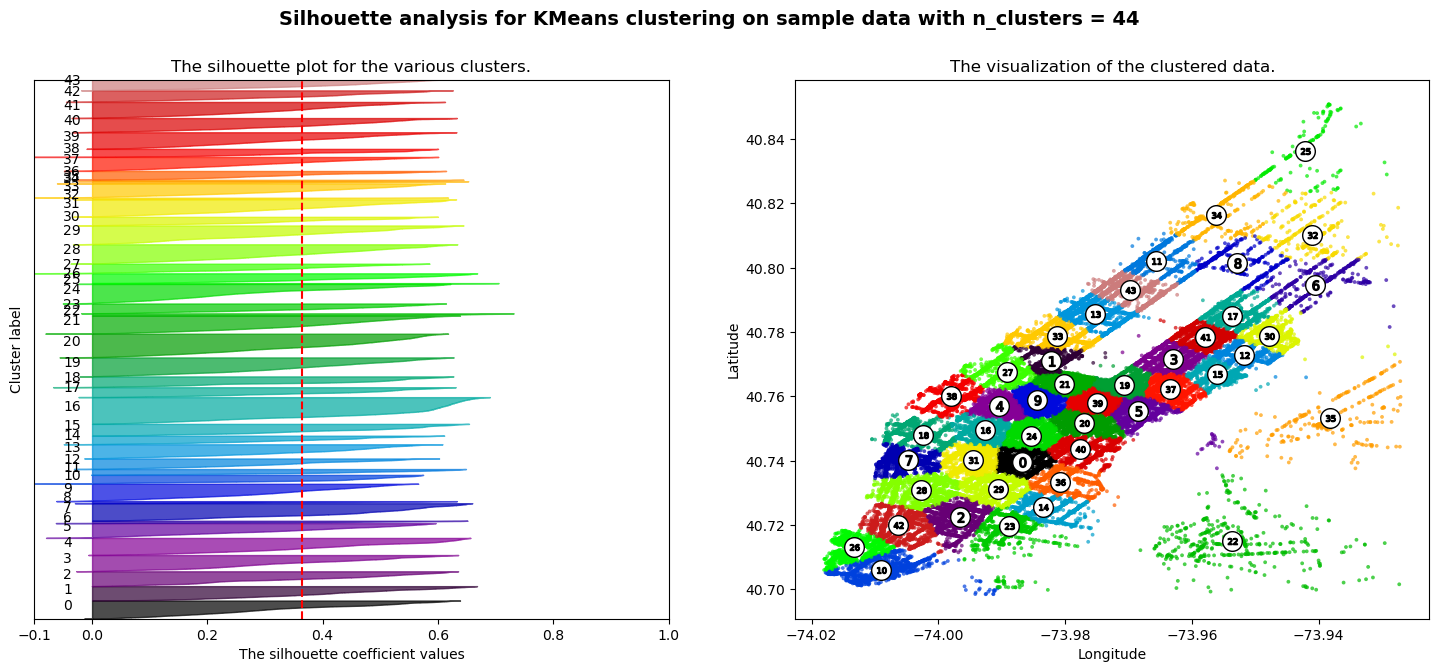

In [27]:
plot_silhouette_analysis(pickup_X, 1.0, [10,44])

Although the highest silhouette score was for 10 clusters, this does not represent what we know to be logical clusters in this area. For example, the pickup locations in the South East of the study area are much further from Manhatten than neighbouring clusters (and across water) so it would make sense to choose a cluster value where these are separated from the other Manhatten clusters. The next best silhouette score that does this is for 44 clusters.

Therefore, let's break the pickup locations into 44 clusters.

In [28]:
# Create pickup cluster lables for all data using 44 clusters
clusters = 44
pickup_model = KMeans(n_clusters=clusters, random_state=42, n_init='auto')
pickup_model.fit(pickup_X.values)
clean_df['pickup_cluster'] = pickup_model.labels_

### KMeans Clustering for dropoff locations

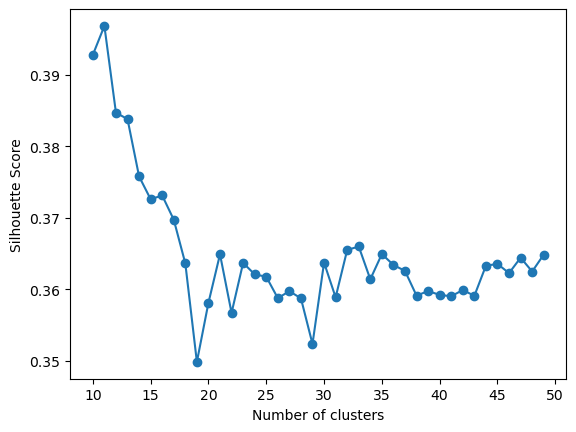

In [29]:
# Plot dropoff location silhouette analysis results for clusters between 10 and 50
dropoff_X = clean_df[['dropoff_longitude', 'dropoff_latitude']]
plot_silhouette_scores(dropoff_X, 0.1, range(10,50))

You can see from the above plot that the silhouette score is the highest at 11 with another local maxima at 33.

Let's plot the silhouette results for 11 and 33 clusters on the data to compare the results visually.

For n_clusters = 11 The average silhouette_score is : 0.38583995100678403
For n_clusters = 33 The average silhouette_score is : 0.3574553959097809


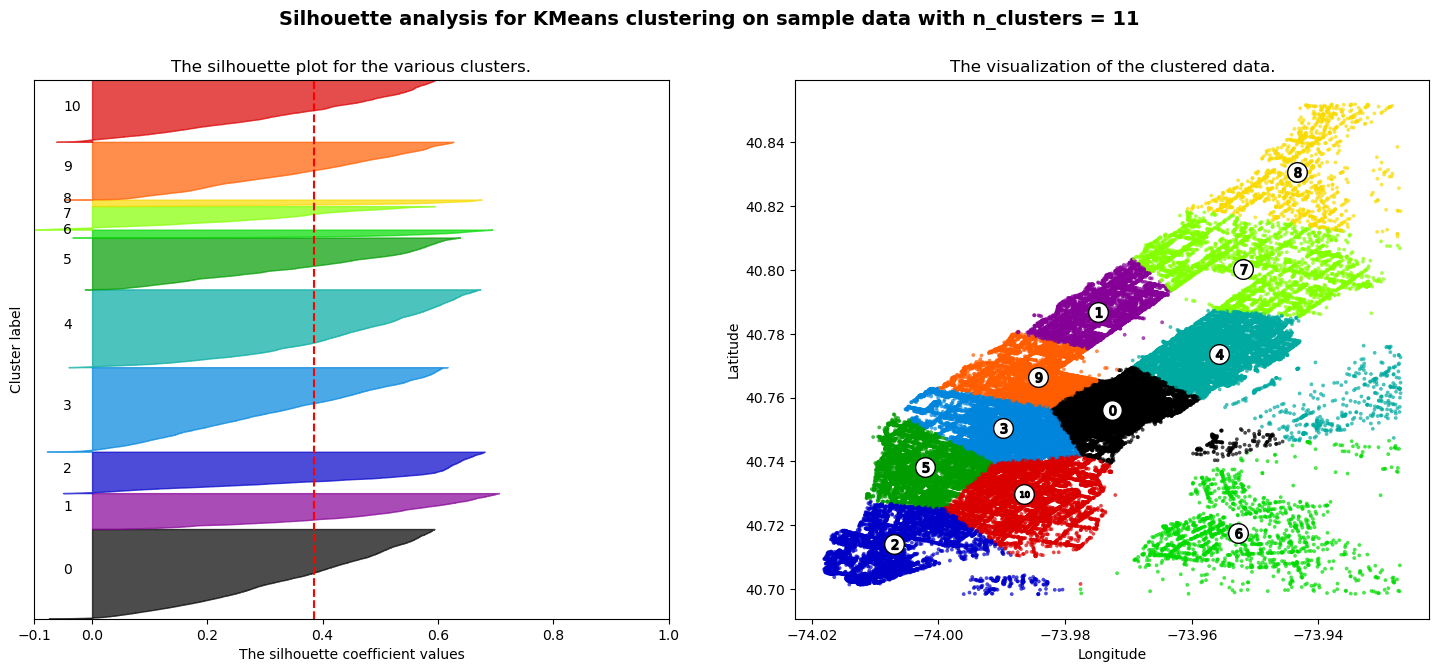

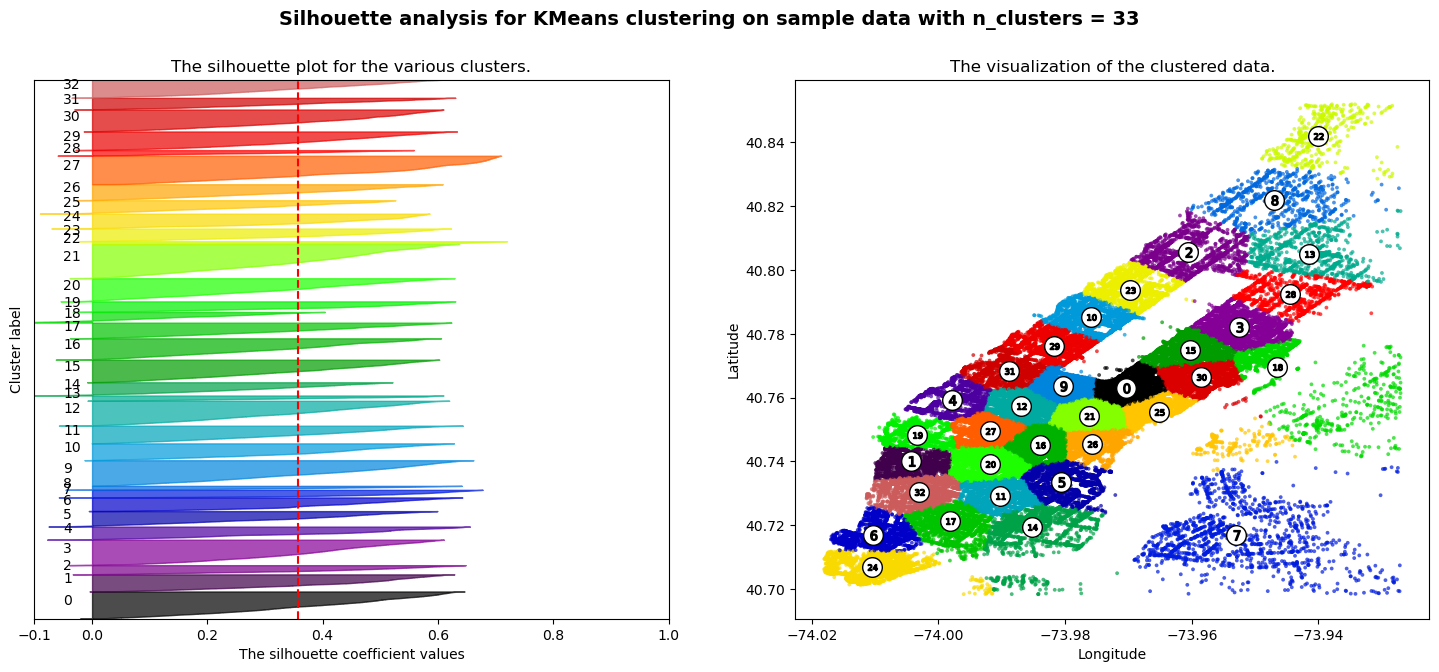

In [30]:
plot_silhouette_analysis(dropoff_X, 1.0, [11,33])

Although the highest silhouette score was for 11 clusters, this does not accurately represent what we know to be logical clusters in this area. For example, the pickup locations in the South East of the study area are much further from Manhatten (and across water) than neighbouring clusters so it would make sense to choose a cluster value where these are separated from the other Manhatten clusters. The next best silhouette score that does this is for 33 clusters.

Therefore, let's break the pickup locations into 33 clusters.

In [31]:
# Create dropoff cluster lables for all data using 29 clusters
clusters = 33
dropoff_model = KMeans(n_clusters=clusters, random_state=42, n_init='auto')
dropoff_model.fit(dropoff_X.values)
clean_df['dropoff_cluster'] = dropoff_model.labels_

## Cluster the hours using KMeans Clustering

There are only 24 possible combinations of hour_sin and hour_cos, but let's see if there are any local maxima that we can clusters these hours into.

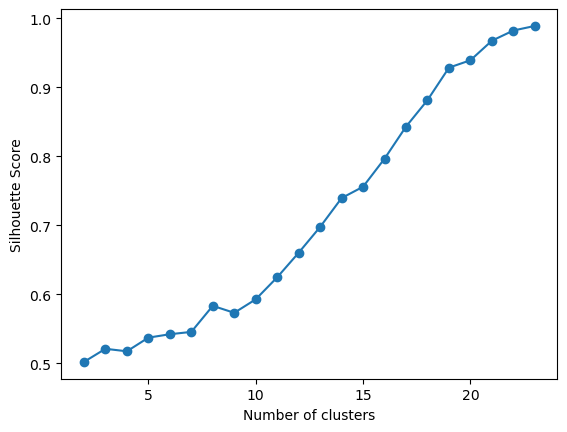

In [32]:
# Plot hours silhouette analysis results for clusters between 2 and 24
hours_X = clean_df[['hour_sin', 'hour_cos']]
plot_silhouette_scores(hours_X, 0.1, range(2,24))

So naturally the optimal cluster is at 24, meaning each hour of the day is already regarded as its own cluster. Looking at the trend in this graph, I don't think there is any logical reason to perform clustering on the hour of day, but let's create a single cluster column to replace the hour_sin and hour_cos values. (This should be equivalent to using the original hour value)

In [33]:
# Create hour cluster lables for all data using 24 clusters
clusters = 24
hour_model = KMeans(n_clusters=clusters, random_state=42, n_init='auto')
hour_model.fit(hours_X.values)
clean_df['hour_cluster'] = hour_model.labels_

## Cluster the days using KMeans Clustering

There are only 7 possible combinations of day_sin and day_cos, but let's see if there are any local maxima that we can cluster these days into (maybe weekend and weekday?)

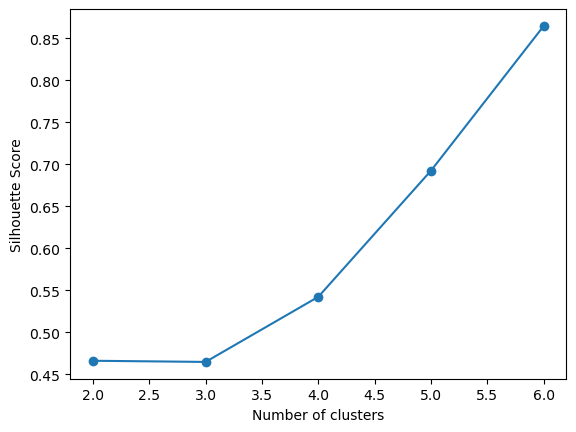

In [34]:
# Plot hours silhouette analysis results for clusters between 2 and 24
days_X = clean_df[['day_sin', 'day_cos']]
plot_silhouette_scores(days_X, 0.1, range(2,7))

So naturally the optimal cluster is at 7, meaning each hour of the day is already regarded as its own cluster. Looking at the trend in this graph, I don't think there is any logical reason to perform clustering on the day of week, but let's create a single cluster column to replace the day_sin and day_cos values. (This should be equivalent to using the original day value)

In [35]:
# Create day cluster lables for all data using 7 clusters
clusters = 7
day_model = KMeans(n_clusters=clusters, random_state=42, n_init='auto')
day_model.fit(days_X.values)
clean_df['day_cluster'] = day_model.labels_

## Cluster the routes using KMeans Clustering
Let's look at clustering specific routes from one pickup cluster to a dropoff cluster.

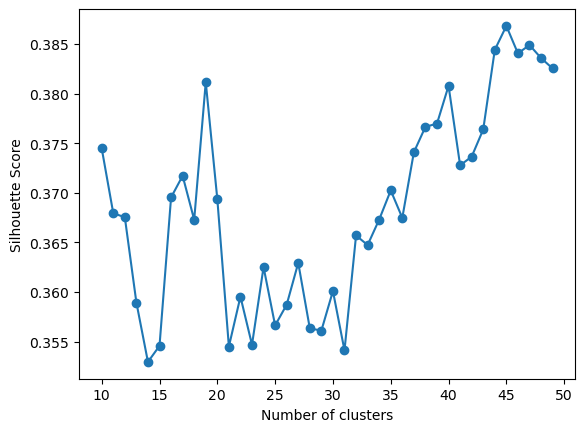

In [36]:
# Plot route silhouette analysis results for clusters between 10 and 50
route_X = clean_df[['pickup_cluster', 'dropoff_cluster']]
plot_silhouette_scores(route_X, 0.1, range(10,50))

Looking at the above graph there is a pretty clear maximum at 45, so let's use this to cluster routes.

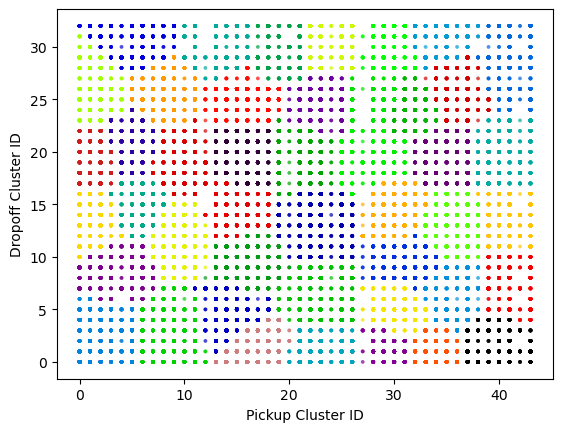

In [37]:
# Create route cluster lables for all data using 45 clusters
clusters = 45
route_model = KMeans(n_clusters=clusters, random_state=42, n_init='auto')
route_model.fit(route_X.values)
clean_df['route_cluster'] = route_model.labels_

# Let's confirm the route cluster results for all records in the dataframe
colors = cm.nipy_spectral(clean_df['route_cluster'].astype(float)/ clusters )
plt.scatter(clean_df['pickup_cluster'], clean_df['dropoff_cluster'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
plt.xlabel('Pickup Cluster ID')
plt.ylabel('Dropoff Cluster ID')
plt.show()

Looking at the graph above, you can see how the various pickup and dropoff cluster IDs have been grouped into evenly distrubted routes

### Create final model dataframe

Create final dataframe with the columns we want in the training model

In [38]:
final_df = clean_df[['pickup_cluster','dropoff_cluster','route_cluster','passenger_count','hour_cluster', 'day_cluster', 'distance_km', 'trip_duration']]

In [39]:
final_df.describe()

pickup_cluster  dropoff_cluster  route_cluster  passenger_count  \
count   100000.000000    100000.000000  100000.000000     100000.00000   
mean        20.316770        15.542590      20.950120          1.66249   
std         12.497134         9.283285      12.988096          1.31240   
min          0.000000         0.000000       0.000000          1.00000   
25%          9.000000         8.000000       9.000000          1.00000   
50%         21.000000        15.000000      21.000000          1.00000   
75%         31.000000        23.000000      32.000000          2.00000   
max         43.000000        32.000000      44.000000          6.00000   

        hour_cluster    day_cluster    distance_km  trip_duration  
count  100000.000000  100000.000000  100000.000000  100000.000000  
mean       10.236670       2.937940       2.412356     711.522810  
std         6.265985       1.991203       1.742605     438.124337  
min         0.000000       0.000000       0.000769     130.000000  
25%         5.000000       1.000000       1.203613     386.000000  
50%        10.000000       3.000000       1.905790     610.000000  
75%        15.000000       5.000000       3.083761     926.000000  
max        23.000000       6.000000      17.177271    3173.000000

Looking good and ready to train the model

## Predict Taxi Trip Duration using XGBoost

Create training and validation data

In [40]:
X = final_df.iloc[:,:-1]  # Everything but the last column
y = final_df.iloc[:,-1]  # The last column

# Split input and output based on 25% test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [41]:
xgb_regressor=xgb.XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.01, eval_metric='rmse')

In [42]:
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [43]:
xgb_predictions = xgb_regressor.predict(X_test)

In [44]:
# Print metrics
print(f'r2: {r2_score(y_test, xgb_predictions)}')
print(f'rmse: {np.sqrt(mean_squared_error(y_test, xgb_predictions))}')

r2: 0.44433351978461155
rmse: 329.6522909786999


Let's see how much better we can make this model

## Hypertune the XGBoost Model
Let's take a look at a variety of hyperparameters and see which combination works better, at least for a random subset.

In [45]:
# X_train_sample = X_train.sample(frac=0.1)
# y_train_sample = y_train.sample(frac=0.1)

xgb_regressor=xgb.XGBRegressor()
param_grid = {"max_depth": [3, 4, 5, 6],
              "n_estimators": [50, 100, 200, 500],
              "learning_rate": [0.01, 0.025, 0.05, 0.1]}
search = RandomizedSearchCV(xgb_regressor, param_grid, scoring='r2', n_jobs=-1).fit(X_train, y_train)
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1}


Now let's re-run the model using the best combination of hyperparameters

In [46]:
xgb_regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

In [47]:
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [48]:
xgb_predictions = xgb_regressor.predict(X_test)

In [49]:
# Print metrics
print(f'r2: {r2_score(y_test, xgb_predictions)}')
print(f'rmse: {np.sqrt(mean_squared_error(y_test, xgb_predictions))}')

r2: 0.6417970400339343
rmse: 264.6754034408233


The metrics from the tuned hyperparameters generated a huge increase in the performance of the model. A much higher r2 value, and a much lower rmse. This is a great result from tuning the hyperparameters.

Now let's plot the feature importance against F-score

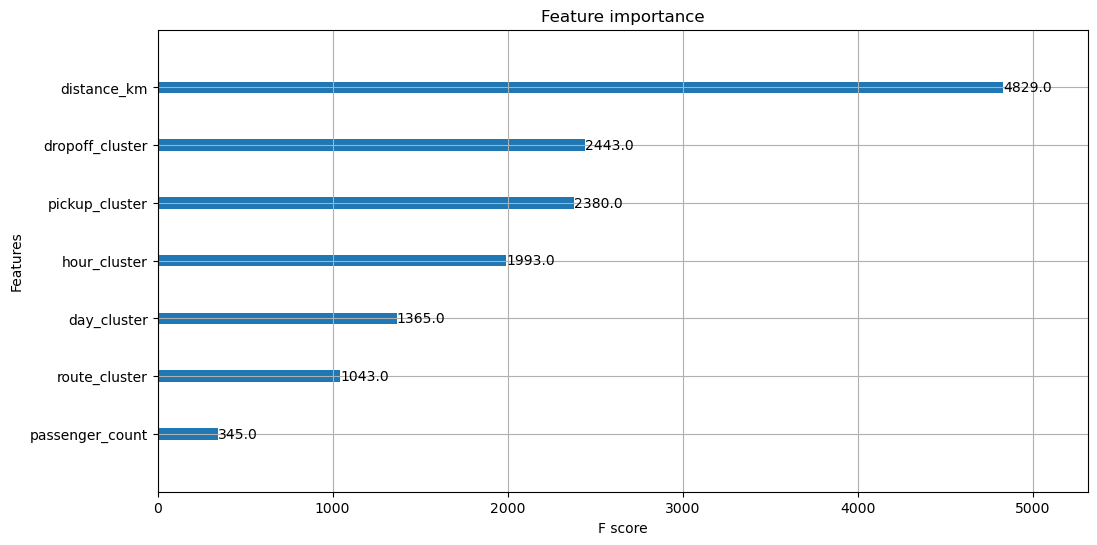

In [50]:
fig, ax = plt.subplots(figsize=(12,6))
plot_importance(xgb_regressor, ax=ax)
plt.show();

The feature importance plot is intutive. The time it takes for a particular journey is largely dependent on the distance, which is the most accurate metric of location. The next most important was the pickup and dropoff clustered locations, which is great news. It means that the location still plays an important part in the model.
Next on the list, it seems that the hour of day is more important than the day of the week, which makes sense due to human behaviour at certain times (e.g. work commutes etc.).
It appears that the route does not seem to matter. What takes precedence is how far the journey is and at what time of day, which seems intutive.
Lastly, the passenger count has the least importance, which is expected since it has no bearing on how quickly or slowly a car can travel (unless the taxi is make multiple stops with a greater number of passengers, which this data does not appear to do).

In [51]:
## Output to Shapefile
output_df = clean_df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'pickup_cluster', 'dropoff_cluster', 'route_cluster', 'passenger_count', 'hour', 'day', 'distance_km', 'trip_duration']]

pickup_df = gpd.GeoDataFrame(output_df, geometry=gpd.points_from_xy(output_df.pickup_longitude, output_df.pickup_latitude), crs=f"EPSG:4326").clip(land_boundary)
pickup_df.to_file('pickup_locations.shp', driver='ESRI Shapefile')

dropoff_df = gpd.GeoDataFrame(output_df, geometry=gpd.points_from_xy(output_df.dropoff_longitude, output_df.dropoff_latitude), crs=f"EPSG:4326").clip(land_boundary)
dropoff_df.to_file('dropoff_locations.shp', driver='ESRI Shapefile')

/tmp/ipykernel_996/1480494958.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  pickup_df.to_file('pickup_locations.shp', driver='ESRI Shapefile')
/tmp/ipykernel_996/1480494958.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  dropoff_df.to_file('dropoff_locations.shp', driver='ESRI Shapefile')


## Output in ArcGIS Pro

The figure below shows the pickup locations symbolized by pickup cluster. This highlights the extent of each pickup cluster.

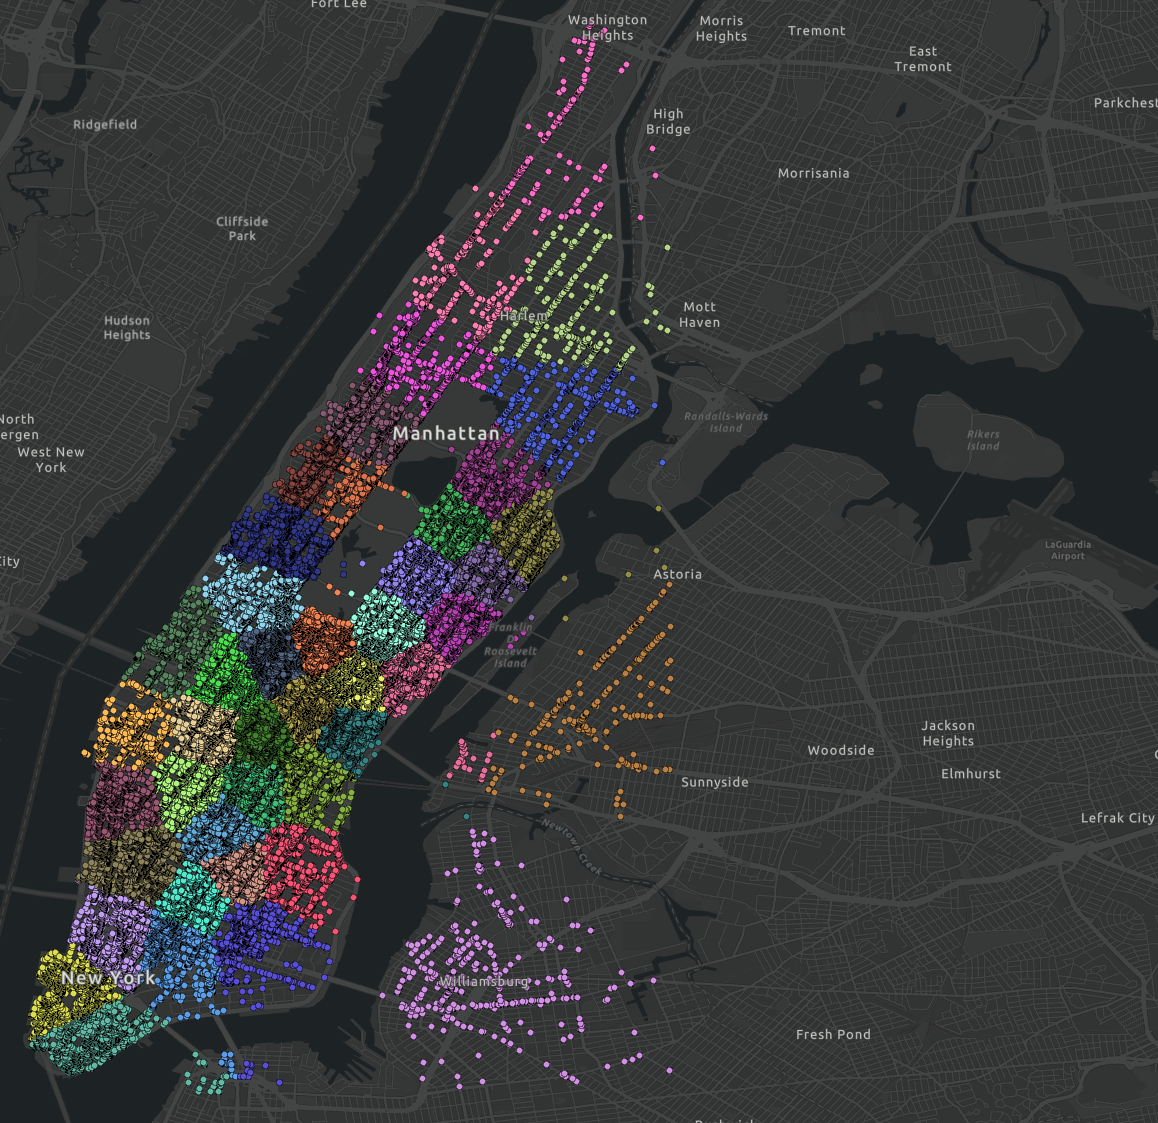

This next figure below shows the pickup locations symbolized by route cluster i.e. which pickup cluster location has the same dropoff cluster location. You can see that there are some noticable patterns, but there is still a lot of variability in the routes, most likely due to the large number of pickup, dropoff and route clusters that were chosen. A much smaller number of clusters for each variable would show more obvious patterns in route similiarities.

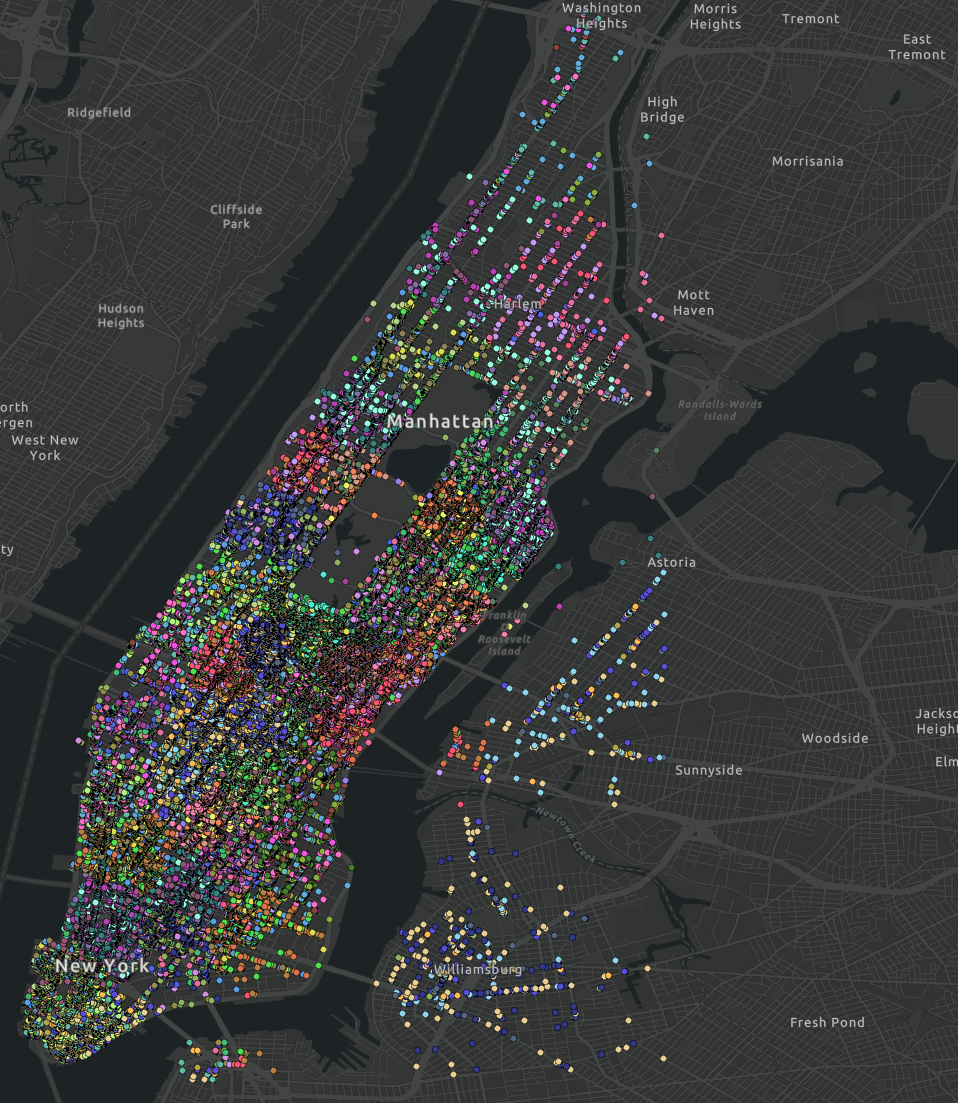